In [53]:
import gym
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import warnings
from sklearn.exceptions import ConvergenceWarning
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [54]:


# ── Hyperparameters ───────────────────────────────────────────────────────────
ENV_ID       = "CartPole-v1"
N_EPISODES   = 160       # total episodes N
N_INTRINSIC  = 40    # intrinsic‐exploration episodes n*
EPISODE_LEN  = 200       # max steps per episode
COST_LIMIT   = 0.3       # allowable average cost per episode
RAND_SEARCH  = 100       # candidates per inner solve
SEARCH_STD   = 0.5       # neighbor std for random search
SEED         = 1
num_traj=2
Position_safe_lb=-1.9
Position_safe_ub=1.9
Pole_Angle_safe_ld= -0.15
Pole_Angle_safe_ud=   0.15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Position_lb=-4.8
Position_ub=4.8

Velocity_lb=-10000
Velocity_ub=10000
Pole_Angle_ld= -0.418 
Pole_Angle_ud= 0.418 


np.random.seed(SEED)
def cal_cost(state,action,next_state):
    cost1=0
    cost2=0
    if Position_safe_lb >=next_state[0]:
        cost1=Position_safe_lb-next_state[0]
    if Position_safe_ub <=next_state[0]:
        cost1=next_state[0]-Position_safe_ub
    if next_state[2]<=Pole_Angle_safe_ld:
        cost2=Pole_Angle_safe_ld-next_state[2]
    if next_state[2]>=Pole_Angle_safe_ud:
        cost2=next_state[2]-Pole_Angle_safe_ud
    return np.maximum(cost1,10*cost2)
       
# ── Dynamics Model via GP ────────────────────────────────────────────────────
# class GPModel:
#     def __init__(self):
#         # RBF + white noise kernel
#         kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3)
#         # one GP per state‐dimension
#         self.gps = [GaussianProcessRegressor(kernel) for _ in range(4)]
#         self.X = []   # (s,a) pairs
#         self.Y = []   # s' targets

#     def update(self, transitions):
#         # transitions: list of (s,a,s')
#         X_new = [np.hstack((s, [a])) for (s,a,s1,_,_) in transitions]
#         Y_new = [s1 for (s,a,s1,_,_) in transitions]
#         self.X += X_new
#         self.Y += Y_new
#         X = np.array(self.X)
#         Y = np.array(self.Y)
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore", category=ConvergenceWarning)
#             for i, gp in enumerate(self.gps):
#                 gp.fit(X, Y[:, i])

#     def predict(self, s, a):
#         x = np.hstack((s, [a]))[None, :]
#         mus, sigs = [], []
#         for gp in self.gps:
#             mu, sigma = gp.predict(x, return_std=True)
#             mus.append(mu.item())
#             sigs.append(sigma.item())
#         return np.array(mus), np.array(sigs)

    
def gaussian_nll_loss(y_pred_mean, y_pred_log_var, y_true):
    # NLL for a Gaussian: log(sigma^2) + (y - mu)^2 / sigma^2
    loss = 0.5 * (y_pred_log_var + ((y_true - y_pred_mean) ** 2) / torch.exp(y_pred_log_var))
    return loss.mean()

# def gaussian_nll(mu, var, y):
#     # mu, var, y: all (B, nS)
#     return 0.5 * (torch.log(var) + (y - mu)**2 / var).sum(dim=-1)

# class GaussianTransitionModel(nn.Module):
#     def __init__(self, n_states, n_actions, hidden_size=128):
#         super().__init__()
#         self.backbone = nn.Sequential(
#             nn.Linear(n_states + n_actions, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#         )
#         # two heads: one for mean, one for log‐variance
#         self.fc_mu      = nn.Linear(hidden_size, n_states)
#         self.fc_logvar  = nn.Linear(hidden_size, n_states)
        
#     def forward(self, s_onehot, a_onehot):
#         x    = torch.cat([s_onehot, a_onehot], dim=-1)
#         h    = self.backbone(x)
#         mu   = self.fc_mu(h)             # (B, n_states)
#         logv = self.fc_logvar(h)         # (B, n_states)
#         # ensure positivity of variance
#         var  = torch.exp(logv)           # (B, n_states)
#         return mu, var
        
#     def update(self,trans):
#         optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
#         for i in range(len(trans)):
#             optimizer.zero_grad()
#             (s, a, s1, r, cost)=trans[i]
#             data=np.concatenate((s, a.reshape(1, )), axis=0)
#             data_tensor=torch.from_numpy(data).float().unsqueeze(0).to(device)
#             labels=np.array(s1).reshape(1,)
#             labels_tensor=torch.from_numpy(labels).float().unsqueeze(0).to(device)
#             mean, log_var = self.forward(data_tensor)
#             loss = gaussian_nll(mean, log_var, labels_tensor)
#             loss.backward()
#             optimizer.step()


class ProbabilisticRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.mean_head = nn.Linear(hidden_dim, 4)
        self.log_var_head = nn.Linear(hidden_dim, 4)  # log variance for stability

    def forward(self, x):
        h = self.shared(x)
        mean = self.mean_head(h)
        log_var = self.log_var_head(h)
        return mean, log_var  # we return log variance to keep it numerically stable
    
    def update(self,trans):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        for i in range(len(trans)):
            optimizer.zero_grad()
            (s, a, s1, r, cost)=trans[i]
            data=np.concatenate((s, np.array(a).reshape(1, )), axis=0)
            data_tensor=torch.from_numpy(data).float().unsqueeze(0).to(device)
            labels_tensor=torch.from_numpy(s1).float().unsqueeze(0).to(device)
            mean, log_var = self.forward(data_tensor)
            loss = gaussian_nll_loss(mean, log_var, labels_tensor)
            loss.backward()
            optimizer.step()

# ── Policy: theta ∈ R⁴ → action ∈ {0,1} ───────────────────────────────────────────
def policy(s, theta):
    z = theta.dot(s)
    return 1 if np.tanh(z) > 0 else 0

# ── Evaluate objectives via GP rollout ────────────────────────────────────────
def eval_episode_model(model, theta, intrinsic):
    s = np.zeros(4)  # start at origin (approx)
    J = 0.0
    C = 0.0
    for _ in range(EPISODE_LEN):
        a = policy(s, theta)
        X=np.concatenate((s, np.array(a).reshape(1, )), axis=0)
        with torch.no_grad():
            X_tensor = torch.from_numpy(X).float().unsqueeze(0).to(device)
        mean, log_var = model(X_tensor)
        # mu, sigma = model.predict(s, a)
        # intrinsic reward = sum of σ
        if intrinsic:
            J += np.exp(log_var.detach().numpy()[0]).sum()
        else:
            # extrinsic reward (CartPole): +1 per step
            state=mean.detach().numpy()[0]
            if s[0]>=Position_lb and s[0]<=Position_ub and  s[2]>=Pole_Angle_ld and s[2]<=Pole_Angle_ud:
                J += 1.0
        cost=cal_cost(s,a,mean.detach().numpy()[0])
        C += cost
        s = mean.detach().numpy()[0]  # use GP‐predicted next state
    # return J / EPISODE_LEN, C / EPISODE_LEN
    return J , C / EPISODE_LEN


def objective_over_ensemble(ensemble, theta, intrinsic):
    Js = []
    Cs = []
    for f in ensemble:
        for i in range(num_traj):
            Jf, Cf = eval_episode_model(f, theta, intrinsic)
            Js.append(Jf)
            Cs.append(Cf)
    # max_{f ∈ Qₙ} J  and  max_{f ∈ Qₙ} C
    J_max = np.max(Js)
    C_max = np.max(Cs)
    return J_max, C_max


# ── Simple random‐search planner as a stand‐in for LBSGD ───────────────────────
def solve_barrier(ensemble, theta0, intrinsic, lam=10000.0):
    """
    Maximize J - λ * max(0, C - COST_LIMIT) via neighborhood random search.
    """
    best = theta0.copy()
    Jb, Cb = objective_over_ensemble(ensemble, best, intrinsic)
    score_b = Jb - lam * max(0, Cb - COST_LIMIT)
    for _ in range(RAND_SEARCH):
        theta_cand = best + np.random.randn(*best.shape) * SEARCH_STD
        Jc, Cc = objective_over_ensemble(ensemble, theta_cand, intrinsic)
        score_c = Jc - lam * max(0, Cc - COST_LIMIT)
        if score_c > score_b:
            best, score_b = theta_cand, score_c
    return best

# ── Roll out in the real environment to collect data ───────────────────────────
def rollout_env(env, theta):
    """
    Execute one episode in the *real* CartPole and collect transitions.
    """
    transitions = []
    # reset may also return (obs, info) in Gymnasium—just grab the first item
    s = env.reset()
    if isinstance(s, tuple):
        s = s[0]

    total_reward = 0.0
    total_cost   = 0.0
    num_vio=0
    for t in range(EPISODE_LEN):
        a = policy(s, theta)

        # unpack the 5‐tuple: obs, reward, terminated, truncated, info
        s1, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated

        cost = cal_cost(s,a,s1)
        transitions.append((s, a, s1, r, cost))

        total_reward += r
        total_cost   += cost
        s = s1
        if cost>COST_LIMIT:
            num_vio+=1
        if done:
            break

    avg_cost = total_cost / (t + 1)
    # return transitions, total_reward, avg_cost
    return transitions, total_reward, avg_cost,num_vio

# ── Main two‐phase ACTSAFE loop for CartPole ─────────────────────────────────
# def run():
#     env = gym.make(ENV_ID)
#     model =  ProbabilisticRegressor(input_dim=5, hidden_dim=128)
#     ensemble = [ model ]
#     theta = np.zeros(4)  # initial policy params

#     # 1) Intrinsic‐exploration phase
#     for ep in range(1, N_INTRINSIC + 1):
#         # a) Solve Eq (7): maximize intrinsic bonus under cost limit
#         theta = solve_barrier(ensemble, theta, intrinsic=True)
#         # b) Collect real transitions
#         trans, R, C = rollout_env(env, theta)


#         model.update(trans)
#         print(f"[I⋅{ep}] R={R:.2f}, C={C:.2f}")

#     # 2) Extrinsic‐exploitation phase
#     for ep in range(N_INTRINSIC + 1, N_EPISODES + 1):
#         # a) Solve Eq (8): maximize extrinsic reward under cost limit
#         theta = solve_barrier(ensemble, theta, intrinsic=False)
#         trans, R, C = rollout_env(env, theta)
#         model.update(trans)
#         print(f"[E⋅{ep}] R={R:.2f}, C={C:.2f}")

    # env.close()

# if __name__ == "__main__":
#     main()

In [55]:
# s=np.zeros(4)
# a=int(1)
# X=np.concatenate((s, np.array(a).reshape(1, )), axis=0)

# X_tensor = torch.from_numpy(X).float().unsqueeze(0).to(device)
# model =  ProbabilisticRegressor(input_dim=5, hidden_dim=128)
# mean, log_var = model(X_tensor)
# np.exp(log_var.detach().numpy())[0][0]


In [56]:
env = gym.make(ENV_ID)
model =  ProbabilisticRegressor(input_dim=5, hidden_dim=128)
model1 =  ProbabilisticRegressor(input_dim=5, hidden_dim=128)
model2 =  ProbabilisticRegressor(input_dim=5, hidden_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ensemble = [ model ]
# ensemble = [ model1,model2 ]
theta = np.zeros(4)  # initial policy params
train_data=np.zeros((N_EPISODES,3))
# 1) Intrinsic‐exploration phase
for ep in range(1, N_INTRINSIC + 1):
    # a) Solve Eq (7): maximize intrinsic bonus under cost limit
    theta = solve_barrier(ensemble, theta, intrinsic=True)
    # b) Collect real transitions
    trans, R, C,vio = rollout_env(env, theta)
    train_data[ep,0]=R
    train_data[ep,1]=C
    train_data[ep,2]=vio
    model.update(trans)
    print(f"[I⋅{ep}] R={R:.2f}, C={C:.2f}")

    # 2) Extrinsic‐exploitation phase
for ep in range(N_INTRINSIC + 1, N_EPISODES ):
    # a) Solve Eq (8): maximize extrinsic reward under cost limit
    theta = solve_barrier(ensemble, theta, intrinsic=False)
    trans, R, C ,vio= rollout_env(env, theta)
    train_data[ep,0]=R
    train_data[ep,1]=C
    train_data[ep,2]=vio
    model.update(trans)
    print(f"[E⋅{ep}] R={R:.2f}, C={C:.2f}")


[I⋅1] R=9.00, C=0.14
[I⋅2] R=38.00, C=0.04
[I⋅3] R=102.00, C=0.04
[I⋅4] R=88.00, C=0.04
[I⋅5] R=78.00, C=0.04
[I⋅6] R=200.00, C=0.00
[I⋅7] R=200.00, C=0.00
[I⋅8] R=200.00, C=0.00
[I⋅9] R=90.00, C=0.03
[I⋅10] R=200.00, C=0.01
[I⋅11] R=49.00, C=0.04
[I⋅12] R=110.00, C=0.03
[I⋅13] R=200.00, C=0.00
[I⋅14] R=23.00, C=0.09
[I⋅15] R=9.00, C=0.20
[I⋅16] R=10.00, C=0.18
[I⋅17] R=9.00, C=0.20
[I⋅18] R=9.00, C=0.11
[I⋅19] R=9.00, C=0.14
[I⋅20] R=44.00, C=0.06
[I⋅21] R=200.00, C=0.00
[I⋅22] R=200.00, C=0.00
[I⋅23] R=68.00, C=0.05
[I⋅24] R=61.00, C=0.04
[I⋅25] R=58.00, C=0.04
[I⋅26] R=65.00, C=0.04
[I⋅27] R=200.00, C=0.00
[I⋅28] R=177.00, C=0.02
[I⋅29] R=37.00, C=0.04
[I⋅30] R=10.00, C=0.17
[I⋅31] R=10.00, C=0.09
[I⋅32] R=80.00, C=0.04
[I⋅33] R=120.00, C=0.02
[I⋅34] R=200.00, C=0.00
[I⋅35] R=200.00, C=0.07
[I⋅36] R=200.00, C=0.00
[I⋅37] R=200.00, C=0.00
[I⋅38] R=107.00, C=0.04
[I⋅39] R=95.00, C=0.04
[I⋅40] R=200.00, C=0.00
[E⋅41] R=100.00, C=0.03
[E⋅42] R=200.00, C=0.00
[E⋅43] R=74.00, C=0.03
[E⋅44

In [57]:
np.sum(train_data[:,0]),np.sum(train_data[:,2]),np.sum(train_data[:,2])/np.sum(train_data[:,0])

(17022.0, 439.0, 0.025790153918458465)

In [62]:
# Evaluate the agent's performance
np.random.seed(2025)
test_episodes = 100
max_steps_per_test_episode=200
episode_rewards = []
test_average_cost=np.zeros(test_episodes)
test_epi_length=np.zeros(test_episodes)
test_cost_epi=np.zeros(test_episodes)
test_cost_per_transition=np.zeros((test_episodes,max_steps_per_test_episode))
for episode in range(test_episodes):
    state = env.reset()[0]
    episode_reward = 0
    done = False
    for step in range(max_steps_per_test_episode):
   
        action=policy(state,theta)       # action = new_agent.act(state,eps=0)
        next_state, reward, done, truncated, _ = env.step(action)
        cost=cal_cost(state,action,next_state)
        episode_reward += reward
        state = next_state
        test_epi_length[episode]+=1
        test_cost_epi[episode]+=cost
        test_cost_per_transition[episode,step]=cost
        if done:
            break

    test_average_cost[episode]=test_cost_epi[episode]/test_epi_length[episode]
    episode_rewards.append(episode_reward)

average_reward = sum(episode_rewards) / test_episodes
print(f"Average reward over {test_episodes} test episodes: {average_reward:.2f}")

Average reward over 100 test episodes: 200.00


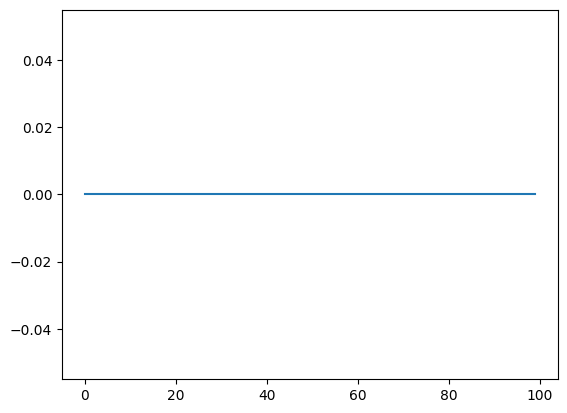

In [63]:
plt.plot(test_cost_epi)

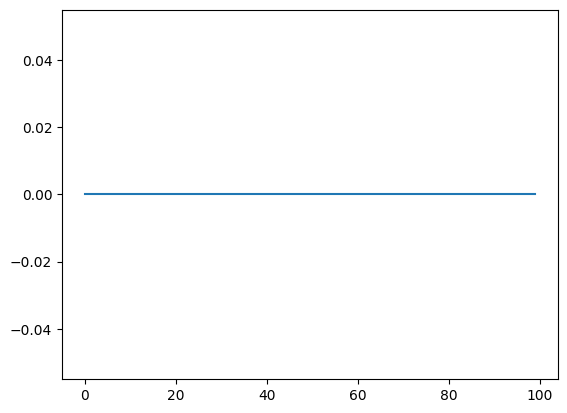

In [64]:
plt.plot(test_average_cost)

In [65]:
np.argmax(test_cost_per_transition)

0